## Load Data

In [1]:
import numpy as np
import tensorflow as tf
import keras as kr

import data
import net

import time
import matplotlib.pyplot as plt


%matplotlib inline
%load_ext autoreload
%autoreload 2


X = []
y = []
Xt = []
yt = []


s0 = []
sv0 = []

n_s = 22
n_test = 50

for i in range(1, 10):
    xi, yi = data.load(i)
    yi = data.recode_y(yi)
    
    xi, yi = data.drop_nan(xi, yi)
    
    xi, yi = data.shuffle(xi[:, :n_s], yi)
    
    yi = kr.utils.to_categorical(yi)
    
    Xt.append(xi[:n_test])
    yt.append(yi[:n_test])
    
    X.append(xi[n_test:])
    y.append(yi[n_test:])
    

    print("Shape %d:" % i, X[-1].shape)
print("Data Loaded")

Using TensorFlow backend.


Shape 1: (237, 22, 1000)
Shape 2: (236, 22, 1000)
Shape 3: (236, 22, 1000)
Shape 4: (234, 22, 1000)
Shape 5: (232, 22, 1000)
Shape 6: (235, 22, 1000)
Shape 7: (238, 22, 1000)
Shape 8: (232, 22, 1000)
Shape 9: (228, 22, 1000)
Data Loaded


#### Preprocessing

In [2]:
mean = []
var = []
X_train = None
y_train = None

X_test = None
y_test = None

X_val = None
y_val = None

X_train = np.concatenate(X, axis=0)
X_test = np.concatenate(Xt, axis=0)
# X_val = np.concatenate(Xv, axis=0)

y_train = np.concatenate(y, axis=0)
y_test = np.concatenate(yt, axis=0)
# y_val = np.concatenate(yv, axis=0)
print("Data merged")


butt = 1
if butt:
    X_train = data.butter_band(X_train, 4, 120)
    X_test = data.butter_band(X_test, 4, 120)
    print("Butter filter applied")

#----------------------------------------------------------#
# Augmenting

augmented_freq = False
ceil = False
freqz = (8, 12, 30)
if augmented_freq:
    X_train = data.augment_frequency(X_train, freqz, ceiling=ceil)
    X_test = data.augment_frequency(X_test, freqz, ceiling=ceil)
    print("Freqeuncy augmentation applied")
   

der = False
der_o = 1
if der:
    X_train = data.diff(X_train, der_o)
    X_test = data.diff(X_test, der_o)
    print("Derivative augmented - ord %d" % der_o)


poww = False
if poww:
    X_train = data.power(X_train, l=22)
    X_test = data.power(X_test, l=22)
    print("Short power augmented")

#----------------------------------------------------------#
# Finishing touches

norm = True
if norm:
    ax = (0, 2)
    X_train, m, v = data.normalize_data(X_train, None, None, axis=ax)
    X_test, _, _ = data.normalize_data(X_test, m, v)#, None, None, axis=ax)
    

vally = True
if vally:
    X_train, y_train = data.shuffle(X_train, y_train)
    val_split = 0.2
    num_val = int(val_split*(y_train.shape[0]))
    X_val = X_train[:num_val]
    X_train = X_train[num_val:]
    y_val = y_train[:num_val]
    y_train = y_train[num_val:]
    print("Data standardized")


win = True
window = 500
stride = 50
start = 0

if win:
    X_train, y_train = data.windowing(X_train, y_train, start, window, stride=stride)
    X_test, y_test = data.windowing(X_test, y_test, start, window, stride=stride)
    if vally:
        X_val, y_val = data.windowing(X_val, y_val, start, window, stride=stride)
    print("Windowing applied: w {}; s {}".format(window, stride))


noise = 0
if noise > 0:
    X_train, y_train = data.augment_noise(X_train, y_train, p=noise)
    print("Noise augmented")
    

X_train = data.swap_axis(X_train)
X_test = data.swap_axis(X_test)
if vally:
    X_val = data.swap_axis(X_val)
    
print("Preprocessing complete. Train shape: {}".format(X_train.shape))

Data merged
Butter filter applied
Data standardized
Windowing applied: w 500; s 50
Preprocessing complete. Train shape: (18557, 500, 22)


# RNN

In [3]:
RNNconfig = {
    'num_steps' : X_train.shape[1],
    'sensors' : X_train.shape[2],
    # LSTM
    'state_size' : 32, #TODO
    'state_size2' : 128,
    'state_size3' : 64,
    # Dense
    'fc_size' : 64,
    'fc_size2' : 50,
    # CNN
    'filters' : 32,
    'strides' : 1,
    # Output
    'output_size' : 4,
    
    # Activations
    'c_act' : 'relu',
    'r_act' : 'hard_sigmoid',
    'rk_act' : 'tanh',
    
    'batch_size' : 64,
    'learning_rate' : 0.0012,
    'epochs' : 30,
    'reg' : 0.0001,
    
    'rec_drop': 0.32,
    'drop' : 0.5,
    'cnn_drop' : 0.6,
}
# print(RNNconfig)
RNN = net.RNN(RNNconfig)

# RNN.build_conv1d()
# RNN.build_simple()
RNN.build_model(inception=True, res=True, maxpool=False, avgpool=True, batchnorm=True)

m = RNN.model
print(m.summary())

tic = time.time()
if vally:
    history = RNN.train(X_train, y_train, X_val, y_val, verbose=1)
else:
    history = RNN.train(X_train, y_train, verbose=1)

acc = RNN.eval_acc(X_test, y_test)

print("\tTraining time: {}s".format(time.time()-tic))

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
model_3 initialized.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 500, 22)      0                                            
__________________________________________________________________________________________________
conv1d_17 (Conv1D)              (None, 500, 32)      2848        input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_18 (Conv1D)              (None, 500, 32)      5664        input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_19 (Conv1D)              (None, 500, 32)      22560       input_1[0][0]                    
_____

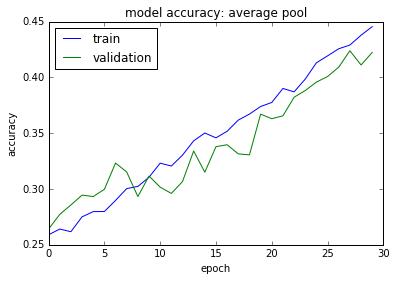

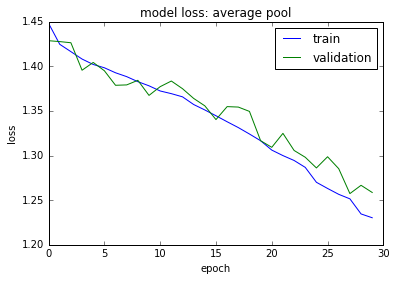

In [6]:
### Plot History
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy: average pool')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss: average pool')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()


In [5]:
print("Max val Acc", np.max(history.history['val_acc']))
print("Min val loss", np.min(history.history['val_loss']))
print("Test Accuracy: {}".format(acc))
print("Max train Acc", np.max(history.history['acc']))


Max val Acc 0.4238825307966334
Min val loss 1.257352067028516
Test Accuracy: 0.4103030303030303
Max train Acc 0.4454922670642126
